In [7]:
import fooof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Investigating spectra

Some questions: 
- will spectral exponents reflect anything interesting?
    - fg.get_params('aperiodic_params', 'exponent') where fg object is 
- Why is the non averaged spectrum so varied?

Other things:
- To see goodness of fit: fg.get_params('r_squared')

## FOOOF Settings

`peak_width_limits` sets the possible lower- and upper-bounds for the fitted peak widths.

`max_n_peaks sets` the maximum number of peaks to fit.

`min_peak_height` sets an absolute limit on the minimum height (above aperiodic) for any extracted peak.

`peak_threshold` sets a relative threshold above which a peak height must cross to be included in the model.

`aperiodic_mode` defines the approach to use to parameterize the aperiodic component.

## FOOOF Group on each cluster

- First just calling FOOOF group on averaged spectra, the kind we see in the study plotting with 4 curves (for dipole only clustering (Brian))
- What do we want in our dataframe?

#### Refs
- https://fooof-tools.github.io/fooof/generated/fooof.FOOOFGroup.html



In [35]:
freqrange = [3,50]

group_df = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in group_df.keys():
    group_df[k] = {'spectral exponent':None, 'results':None}

for i in range(3,15):
    p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(i))
    specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
    group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components
    
    fg = fooof.FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False)
    fg.fit(specfreqs, group_spec, freqrange)
    group_df['cluster {}'.format(i)]['spectral exponent'] = fg.get_params('aperiodic_params', 'exponent')


# Single FOOOF
- fitting for just PL, PR, TL, TR (Wait!  FOOOF_group might already do this!)

In [ ]:
single_spec_fit = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in single_spec_fit.keys():
    single_spec_fit[k] = {'PR':[], 'PL':[], 'TL':[], 'TR':[]}    

# Some tests 
Just to see how to use FOOOF and how to load exported spectral data
- Notice the variance in the non averaged spectrum.  

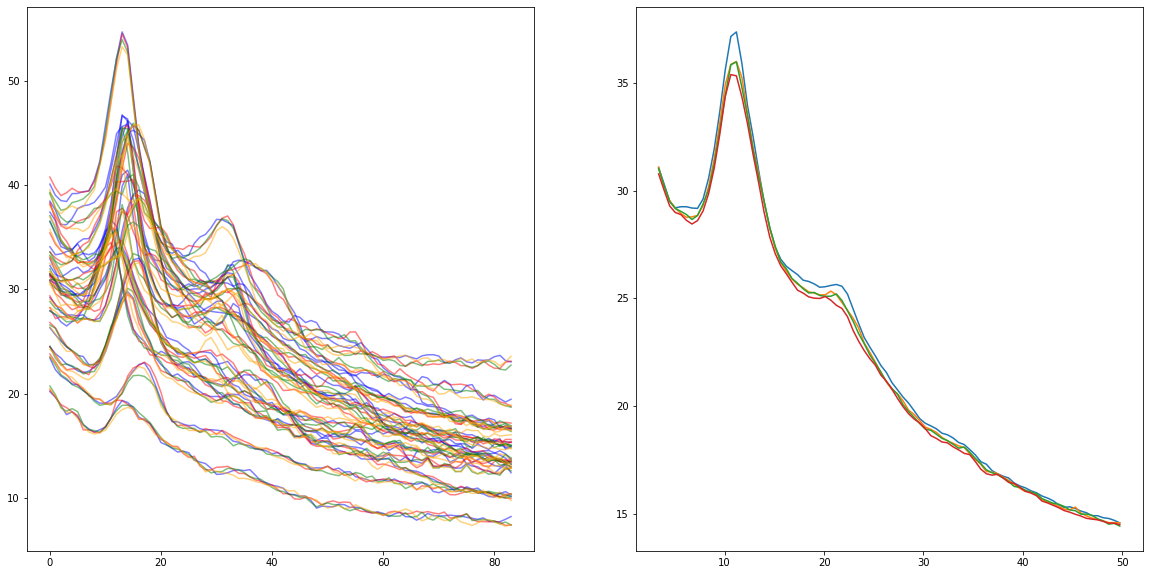

In [22]:
# data from dipole location + ERSP clustering; cluster 5
p_spectrum = loadmat('./data/spectra/dip5_specdata.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']

group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specdata[i][0], color = colors[i], alpha = 0.5)

plt.subplot(1,2,2)
for i in range(4):
    plt.plot(specfreqs, group_spec[i])

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
            

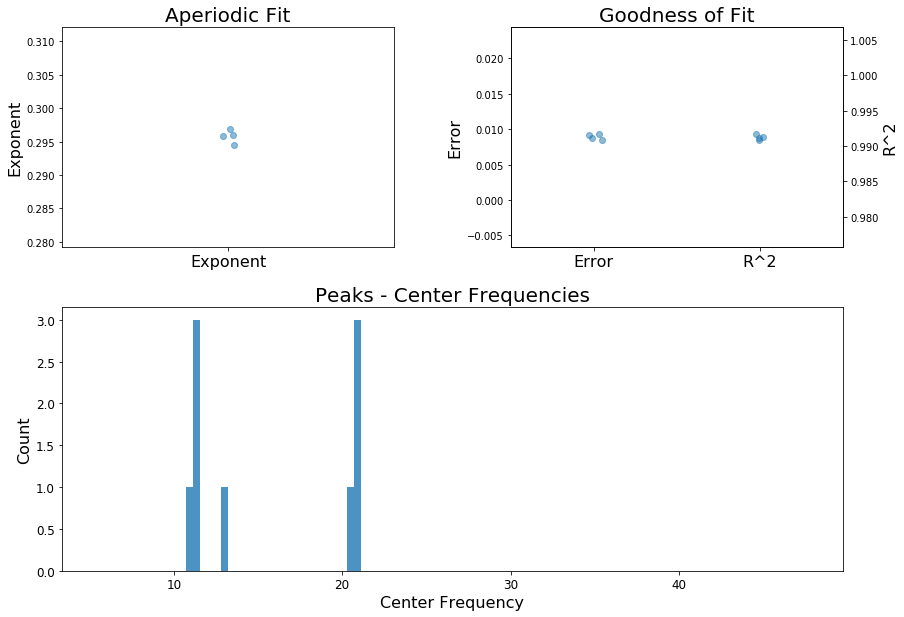

In [42]:
fg = fooof.FOOOFGroup()
fg.fit(specfreqs, group_spec)
freqrange = [3,50]
fg.report(specfreqs, group_spec, freqrange)

## Single FOOOF - One condition


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

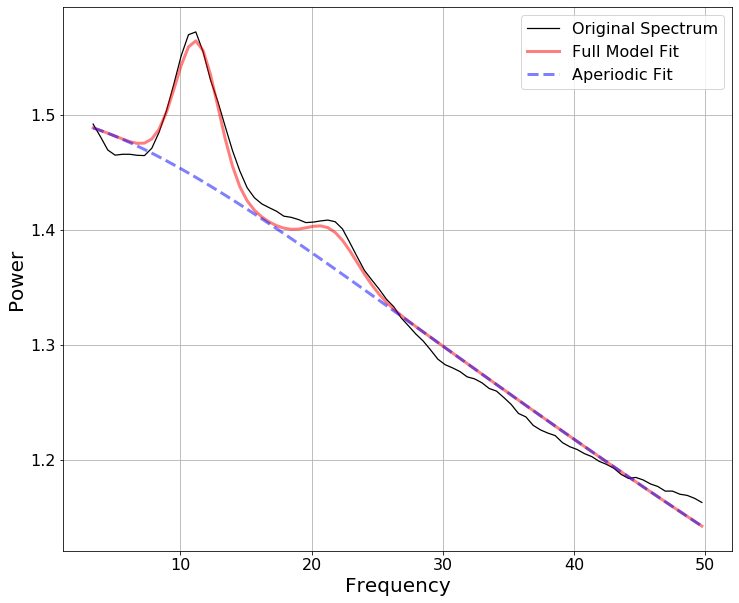

In [4]:
fg = fooof.FOOOF(aperiodic_mode='knee')
fg.fit(specfreqs, group_spec[0])
freqrange = [3,50]
fg.report(specfreqs, group_spec[0], freqrange)

# All dipole only clusters

This spectrum has 229 points for some reason

In [10]:
dip_only_spec = loadmat('./data/dip_only/brian_diponly_all_spectra.mat')


In [18]:
dip_only_spec['specdata'][0][0].shape


(229, 11)

In [20]:
dip_only_spec['specfreqs'].shape

(1, 229)

In [29]:
dip_only_spec3 = loadmat('./data/dip_only/brian_diponly_3_spectra.mat')
specfreqs3, specdata3 = dip_only_spec3['specfreqs'][0], dip_only_spec3['specdata']

group_spec3 = np.array([specdata3[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

In [30]:
dip_only_spec3['specdata'][0][0].shape

(229, 18)

In [34]:
group_spec3.shape

(4, 229)

In [33]:
group_spec.shape

(4, 84)